Bagging与随机森林之二
===

# 4.总结
决策树是一个很流行的机器学习算法。这个算法的性能在特征值的缩放和各种转换的情况下依然保持不变，即使在包含不相关特征的前提下，它依然很健壮。然而，决策树很容易过拟合训练集。它有低的偏差，但是有很高的方差，因此它的准确性不怎么好。bagging是早期的集成方法(ensemble method)，它可以重复地构建多个决策树基于有放回地重新采样，然后集成这些决策树模型进行投票，从而得到更好地准确性。

## 4.1.正确采样率
下面的程序模拟了采样次数以及正确采样率

9 次采样正确率： 0.6214209454492188
109 次采样正确率： 0.8529248106496278
209 次采样正确率： 0.9266174850684462


309 次采样正确率： 0.9611075441817517


409 次采样正确率： 0.9787555232982922


509 次采样正确率： 0.9881786394306903


609 次采样正确率： 0.9933384209653018


709 次采样正确率： 0.9962112837399784


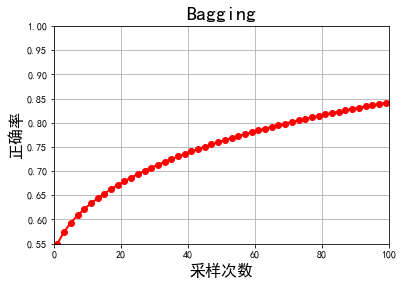

In [1]:
import operator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import reduce
%matplotlib inline

def c(n, k):
    len1 = n - k + 1
    len2 = n + 1
    len3 = k + 1
    c1 = reduce(operator.mul, range(len1, len2))
    c2 = reduce(operator.mul, range(1, len3))
    return  c1 / c2;

def bagging(n, p):
    s = 0
    for i in range(int(n / 2 + 1), int(n + 1)):
        s += c(n, i) * p ** i * (1 - p) ** (n - i)
    return s

n = 800
x = np.arange(1, n, 2)
y = np.empty_like(x, dtype=np.float)
for i, t in enumerate(x):
    y[i] = bagging(t, 0.55)
    if t % 100 == 9:
        print(t, '次采样正确率：', y[i])
mpl.rcParams[u'font.sans-serif'] = u'SimHei'
mpl.rcParams[u'axes.unicode_minus'] = False
plt.figure(facecolor='w')
plt.plot(x, y, 'ro-', lw=2)
plt.xlim(0,100)
plt.ylim(0.55, 1)
plt.xlabel(u'采样次数', fontsize=16)
plt.ylabel(u'正确率', fontsize=16)
plt.title(u'Bagging', fontsize=20)
plt.grid(b=True)

# 5.使用随机森林算法对鸢尾花数据进行分类

{'max_depth': 3, 'n_estimators': 100}
{'max_depth': 6, 'n_estimators': 300}
{'max_depth': 2, 'n_estimators': 100}
{'max_depth': 5, 'n_estimators': 10}
{'max_depth': 5, 'n_estimators': 1}
{'max_depth': 2, 'n_estimators': 10}


Text(0.5, 0.98, '随机森林对鸢尾花数据的两特征组合的分类结果')

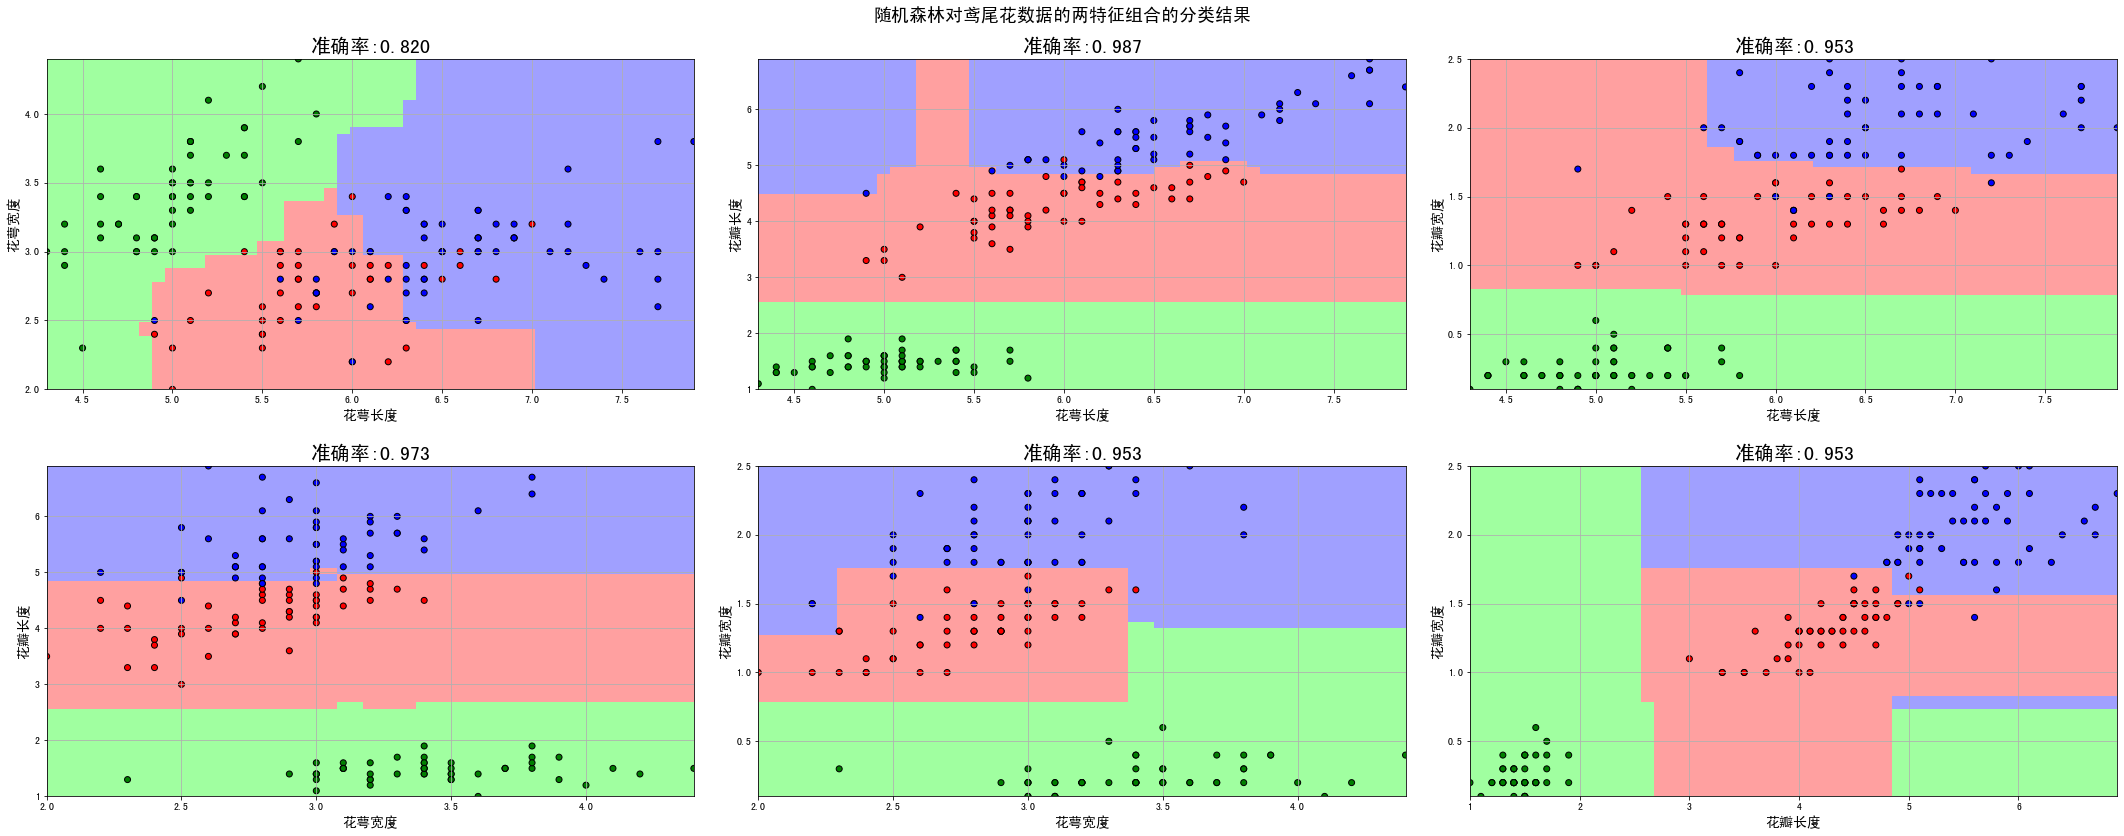

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
import os

data_path = os.path.join("data")


def iris_type(s):
    it = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    return it[s]


iris_feature = u'花萼长度', u'花萼宽度', u'花瓣长度', u'花瓣宽度'

mpl.rcParams['font.sans-serif'] = [u'SimHei']  # 黑体 FangSong/KaiTi
mpl.rcParams['axes.unicode_minus'] = False

data = pd.read_csv(os.path.join(data_path, "iris.data"), header=None)
x_prime = data[np.arange(4)]
y = pd.Categorical(data[4]).codes

feature_pairs = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
plt.figure(figsize=(30, 12), facecolor='w')

max_depth = np.arange(1, 10)
n_estimators = [1, 10, 100, 200, 300]
params_list = dict(max_depth = max_depth, n_estimators = n_estimators)
cv = StratifiedKFold(4)
cv.get_n_splits(x_prime, y)
for i, pair in enumerate(feature_pairs):
    # 准备数据
    x = x_prime[pair]

    # 随机森林
    clf = GridSearchCV(RandomForestClassifier(criterion='entropy'), param_grid=params_list, cv=cv)
    clf.fit(x, y.ravel())

    # 画图
    N, M = 50, 50  # 横纵各采样多少个值
    x1_min, x2_min = x.min()
    x1_max, x2_max = x.max()
    t1 = np.linspace(x1_min, x1_max, N)
    t2 = np.linspace(x2_min, x2_max, M)
    x1, x2 = np.meshgrid(t1, t2)  # 生成网格采样点
    x_test = np.stack((x1.flat, x2.flat), axis=1)  # 测试点

    # 训练集上的预测结果
    y_hat = clf.predict(x)
    print(clf.best_params_)
    y = y.reshape(-1)
    c = np.count_nonzero(y_hat == y)    # 统计预测正确的个数

    # 显示
    cm_light = mpl.colors.ListedColormap(['#A0FFA0', '#FFA0A0', '#A0A0FF'])
    cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])
    y_hat = clf.predict(x_test)  # 预测值
    y_hat = y_hat.reshape(x1.shape)  # 使之与输入的形状相同
    plt.subplot(2, 3, i+1)
    plt.pcolormesh(x1, x2, y_hat, cmap=cm_light)  # 预测值
    plt.scatter(x[pair[0]], x[pair[1]], c=y, edgecolors='k', cmap=cm_dark)  # 样本
    plt.xlabel(iris_feature[pair[0]], fontsize=14)
    plt.ylabel(iris_feature[pair[1]], fontsize=14)
    plt.title('准确率:%.3f' % clf.score(x, y),fontsize=20)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.grid()
plt.tight_layout(2.5)
plt.subplots_adjust(top=0.92)
plt.suptitle(u'随机森林对鸢尾花数据的两特征组合的分类结果', fontsize=18)